# Learning spline regression (with Julia code)
## Benjamin T Vincent
I am currently collecting some data for a research project where I know I will need to apply non-linear regression to some $x, y$ scatter data. There are lots of packages out there to do non-linear regression, but I wanted to understand how these worked behind the scenes. This is proabably overkill, but I think it's important to understand the analyses you are using. This is especially important when it comes to interpreting model parameters for example. So these are my notes that I made to help me simultanously understand piecewise/spline regression, and Julia.

In [1]:
using Distributions, Plots, StatsBase, LsqFit

## Create dataset
First, we'll create a simulated dataset using some true underlying function.

In [2]:
f(x) = 0 + 0.3x -0.6x^2 + 2x^3;

And we can generate some noisy observations

In [3]:
x = sort(rand(Uniform(-1, 1), 100))
y = f.(x) + randn(length(x))*0.5;

Which we can visualise.

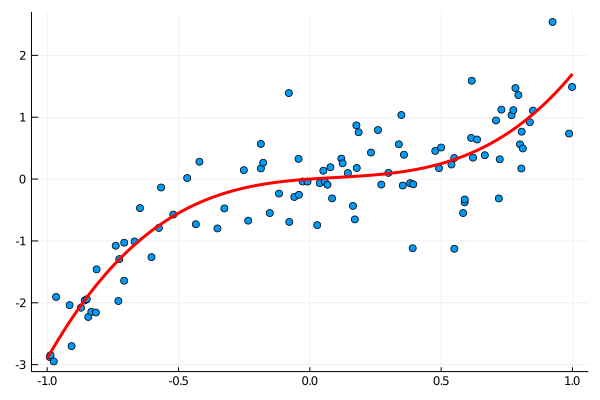

In [4]:
function plot_data(x, y)
    scatter(x, y, label="data")
    xi = [-1:0.01:1;]
    plot!(xi, f.(xi), label="true", lw=3, color=:red)
    plot!(legend=false)
end

plot_data(x, y)

Spline regression involves breaking up the $x$ range into a series of discrete sections, separated by 'knots'. There are various approaches to deciding how many knot points and where to place them, but here we will treat the knots as fixed parameters. We will specify the knot locations based upon dividing up the $x$ data into percentiles.

In [5]:
k = percentile(x, [25, 50, 75])
print(k)

function plot_knots(k)
    vline!(k, color=:black, linestyle=:dash)
    plot!(ylim=(minimum(y)*2, maximum(y)*2))
end

[-0.44243198851091636, 0.10244911280558466, 0.5586337685485958]

plot_knots (generic function with 1 method)

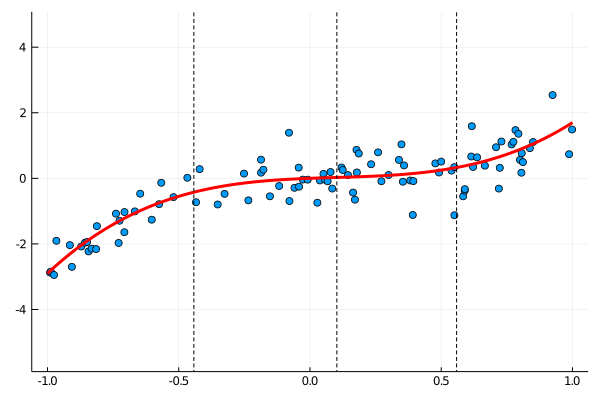

In [6]:
plot_data(x, y)
plot_knots(k)

So piecewise regression methods will take this data and try to fit a model to each of the 4 regions created by these 3 knots. We will look at a few different models which start simple and get more complex:
- piecewise constant functions - this will try to describe each region with a single constant
- piecewise linear functions - these will try to fit each region with a linear fit
- piecewise cubic functions - these fit each region with a cubic polynomial

## Create types
In Julia it makes sense to define some data structures - so we'll start with an abstract type `Piecewise` and some subtypes. All we are really doing here is stating that we have some data structures that consist of knots and parameters. The usefulness of having these will become clear later.

In [7]:
abstract type Piecewise end

struct PiecewiseConstant <: Piecewise
    k  # knots
    β  # parameters
end

struct PiecewiseLinear <: Piecewise
    k  # knots
    β  # parameters
end

struct PiecewiseCubic <: Piecewise
    k  # knots
    β  # parameters
end

## Define functions operating on those types
Now we can define some functions that operate on those these data structures. So these will be our verbs, things that we can do with the data structures. For the moment we know that we want to evaluate the piecewise functions at any given $x$ position, or set of $x$ positions.

Here we define mulitple versions of the `piecewise` function, each of which operates on different parameter types corresponding to the following...

In [8]:
subtypes(Piecewise) 

3-element Array{Any,1}:
 PiecewiseConstant
 PiecewiseCubic
 PiecewiseLinear

So first we will define functions to evaluate the models at a provided $x$ position. All of the cleverness of the piecewise models are captured in these functions.

In [9]:
function piecewise(θ::PiecewiseConstant, x::Float64)
    @assert length(θ.β) == length(θ.k)+1
    # left-most region
    y = θ.β[1] * (x<θ.k[1])
    # middle regions
    for i in 1:length(θ.k)-1
        y += θ.β[i+1] * ((x≥θ.k[i]) & (x≥θ.k[i+1]))
    end
    # right-most region
    y += θ.β[end] * (x≥θ.k[end])
    return y
end


function piecewise(θ::PiecewiseLinear, x::Float64)
    @assert length(θ.β) == length(θ.k)+2
    # left-most region
    y = θ.β[1] + θ.β[2]*x
    # remaining regions
    for i in eachindex(θ.k)
        y += θ.β[i+2] * T(x,θ.k[i])
    end
    return y
end

function piecewise(θ::PiecewiseCubic, x::Float64)
    @assert length(θ.β) == length(θ.k)+4
    # left-most region
    y = θ.β[1] + θ.β[2]*x + θ.β[3]*x^2 + θ.β[4]*x^3
    # remaining regions
    for i in 1:length(θ.k)
        y += θ.β[i+4] * T(x,θ.k[i])^3
    end
    return y
end

T(x::Number, k::Number) = (x-k)*(x≥k);

piecewise(θ::Piecewise, xi::Vector{Float64}) = [piecewise(θ, x) for x in xi];

The first 3 functions are defined to operate for single $x$ values. But very often we will want to evaluate the model for a vector of x values. So the last function is a really neat example of mulitple dispatch...

- if we call `piecewise(θ, x)` and `x` is a vector, then it will iterate over the provided values, each time calling `piecewise(θ, x)`...
- but when `piecewise(θ, x)` is called with `x` being a single number, then it will call the specific function (determined by the type of `θ`) to operate on a single number.

The piecewise linear and cubic models make use of a rectification type function `T(x,k)`. What this does is to gate the influence of model terms to the left of a given knot point and 'reset' the $x$ position to the distance from the knot point. An example is shown below for range of $x$ values and a knot point of -0.5.

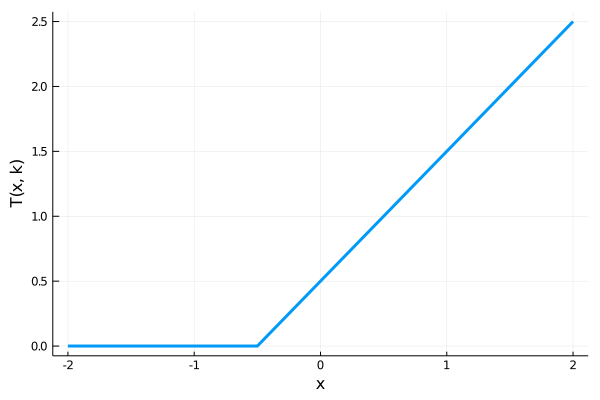

In [10]:
plot([-2:0.01:2;], T.([-2:0.01:2;], -0.5), lw=3)
plot!(xlabel="x", ylabel="T(x, k)", legend=false)

And a function to plot a given piecewise model.

In [11]:
function RecipesBase.plot(θ::Piecewise, xi)
    plot!(xi, piecewise(θ, xi), lw=4, color=:lightgrey, legend=false)
end

## Plot examples with random parameters
First we'll look at a random piecewise constant function.

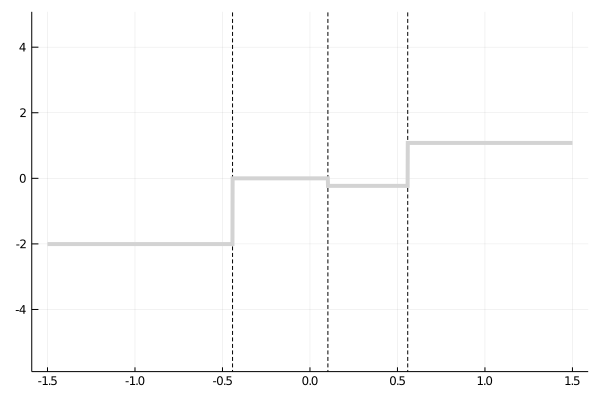

In [12]:
θconst = PiecewiseConstant(k, randn(length(k)+1))

plot()
plot_knots(k)
plot(θconst, [-1.5:0.001:1.5;])

Now a random piecewise linear function.

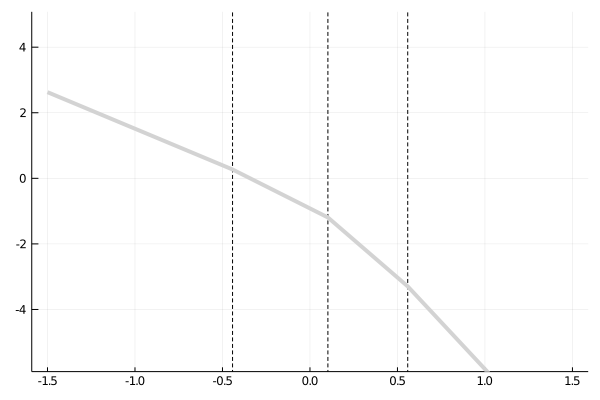

In [13]:
θlin = PiecewiseLinear(k, randn(length(k)+2))

plot()
plot_knots(k)
plot(θlin, [-1.5:0.001:1.5;])

And finally, a piecewise cubic.

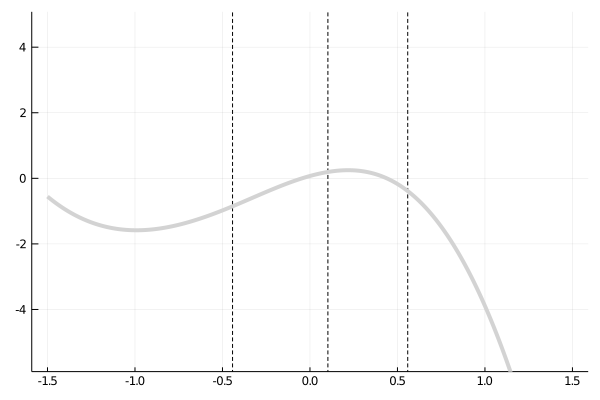

In [14]:
θcubic = PiecewiseCubic(k, randn(length(k)+4))

plot()
plot_knots(k)
plot(θcubic, [-1.5:0.001:1.5;])

## Fitting of parameters to data
To do this we will use the [LsqFit](https://github.com/JuliaNLSolvers/LsqFit.jl) package. We will use this function:

    fit = curve_fit(model, x, y, p0)
    
where `model` takes the inputs `model(x, params)`, and `p0` are some initial parameter values. You could either do this by declaring a new function then provide that to `curve_fit` like this

    model(x, params) = piecewise(PiecewiseConstant(k, params), x)
    fit = curve_fit(model, x, y, p0)
    
or you could just pass in an anonmous function `(x, params) -> piecewise(PiecewiseConstant(k, params), x)` like this

    fit = curve_fit((x, params) -> piecewise(PiecewiseConstant(k, params), x), x, y, p0)


Now we are in a position to do the curve fitting for the piecewise constant.

In [15]:
fit = curve_fit((x, params) -> piecewise(PiecewiseConstant(k, params), x),
    x, y, randn(length(k)+1))
print(fit.param)

[-1.6209895113572612, 0.15383636149668975, 0.39941760445470226, 0.17516564223210015]

And we can visualise how good a fit this is by plotting alongside the data.

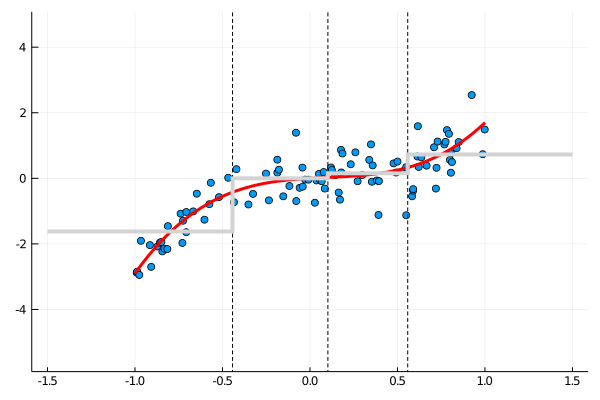

In [16]:
θ = PiecewiseConstant(k, fit.param)

plot_data(x, y)
plot_knots(k)
plot(θ, [-1.5:0.001:1.5;])

Now let's check out this fitting to the other types of model.

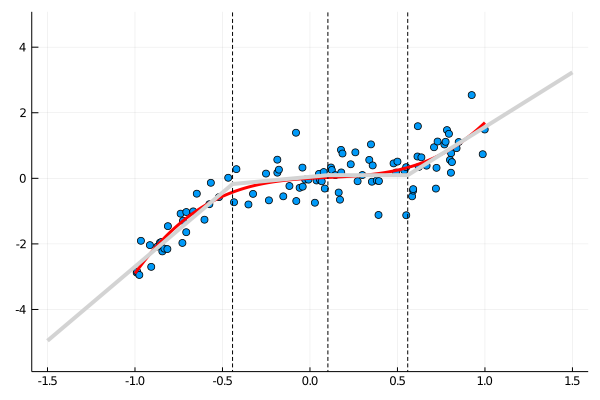

In [17]:
fit = curve_fit((x, params) -> piecewise(PiecewiseLinear(k, params), x),
    x, y, randn(length(k)+2))
plot_data(x, y)
plot_knots(k)
θ = PiecewiseLinear(k, fit.param)
plot(θ, [-1.5:0.001:1.5;])

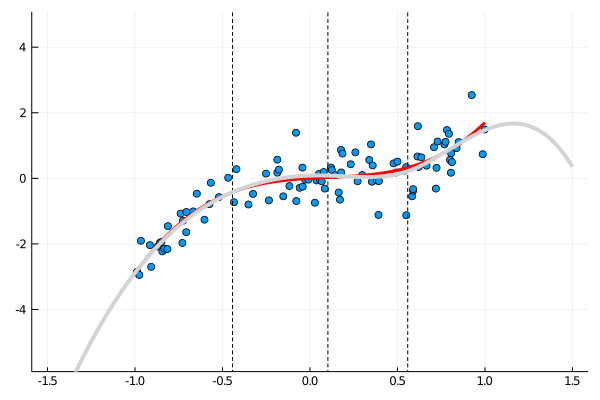

In [18]:
fit = curve_fit((x, params) -> piecewise(PiecewiseCubic(k, params), x),
                x, y, randn(length(k)+4))
plot_data(x, y)
plot_knots(k)
θ = PiecewiseCubic(k, fit.param)
plot(θ, [-1.5:0.001:1.5;])

Each of the models have their own use cases and gradually increase in the number of model parameters. For example, the piecewise constant model could be very useful in situations where you know you have a constant but noise-corrupted signal, which intermittently changes value. The piecewise linear model can be very useful in it's simplicity and interpretability. And the cubic model is good for smoothly varying constant functions.

While cubic models are pretty neat, their performance is quite bad toward the ends of the $x$ data range. This has in turn motivated other models, such a natural cubic splines which we do not cover here. 